In [1]:
from pathlib import Path
from typing import Any

from IPython.display import display # type: ignore
import ipywidgets as widgets # type: ignore

import torch
import supervision as sv
from transformers import AutoProcessor, GroundingDinoProcessor, AutoModelForZeroShotObjectDetection # type: ignore
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


In [29]:
data_path = Path.home() / "src/data"
mobs_path = data_path / "mobs1/640"
image_files = sorted(list(mobs_path.iterdir()))

classes = '''
chicken
cow
creeper
enderman
pig
player
sheep
skeleton
spider
villager
zombie
'''.split()
classes.sort()

classes_minecraft = [f"minecraft {x}" for x in classes]

In [3]:
class ImageDirViewer:
    def __init__(self, image_dir: str | Path, glob_pat: str = "*.png"):
        self.image_dir = image_dir
        self.image_files = sorted(Path(image_dir).glob(glob_pat))
        self.current_file = None
        self.current_index = 0
    
    def view_image_cb(self, index: int):
        self.current_index = index
        self.current_file = self.image_files[index]
        
        img = Image.open(self.current_file)
        print(f"dir={self.image_dir} n_images={len(self.image_files)}")
        print(f"index={index} file={self.current_file.name}")
        display(img)
    
    def show_widget(self):
        slider = widgets.IntSlider(
            value=0,
            min=0,
            max=len(self.image_files) - 1,
            description='Image:',
            continuous_update=False
        )
        widgets.interact(self.view_image_cb, index=slider)


In [4]:
viewer = ImageDirViewer(mobs_path)
viewer.show_widget()

interactive(children=(IntSlider(value=0, continuous_update=False, description='Image:', max=46), Output()), _d…

In [5]:
model_id = "IDEA-Research/grounding-dino-tiny"
processor: GroundingDinoProcessor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

In [30]:
def detect(image: Image) -> dict:
    text_labels = classes

    inputs = processor(images=image, text=text_labels, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model(**inputs)

    results = processor.post_process_grounded_object_detection(
        outputs,
        inputs.input_ids,
        threshold=0.2,
        text_threshold=0.2,
        target_sizes=[image.size[::-1]]
    )

    result: dict[Any, Any] = results[0]
    for box, score, labels in zip(result["boxes"], result["scores"], result["text_labels"]):
        box = [round(x, 2) for x in box.tolist()]
        print(f"Detected {labels} with confidence {round(score.item(), 3)} at location {box}")

    return result

def fix_grounding_dino_result(result: dict) -> tuple[dict, dict]:
    """Work around bug in grounding dino transformer. result["labels"] are supposed to be ints."""
    # Create label mapping
    unique_labels = list(set(result["text_labels"]))
    label2id = {label: idx for idx, label in enumerate(unique_labels)}
    id2label = {idx: label for label, idx in label2id.items()}
    
    # Fix result
    result_fixed = result.copy()
    result_fixed["labels"] = torch.tensor(
        [label2id[label] for label in result["text_labels"]], 
        device=result["boxes"].device
    )
    
    return result_fixed, id2label

def infer(image_file: str | Path):
    image_file = Path(image_file)
    image = Image.open(image_file).convert("RGB")
    result = detect(image)

    result_fixed, id2label = fix_grounding_dino_result(result)
    detections = sv.Detections.from_transformers(result_fixed, id2label=id2label)
    # Create annotators
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()

    # Create labels
    labels = [
        f"{label}: {score:.2f}"
        for label, score in zip(result["text_labels"], result["scores"])
    ]

    # Annotate
    annotated_image = box_annotator.annotate(scene=image.copy(), detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)
    return annotated_image

Detected skeleton villager with confidence 0.219 at location [236.4, 257.81, 285.08, 330.45]
Detected creeper village with confidence 0.26 at location [236.15, 257.49, 285.36, 330.71]
Detected skeleton with confidence 0.236 at location [302.34, 165.39, 380.88, 316.75]


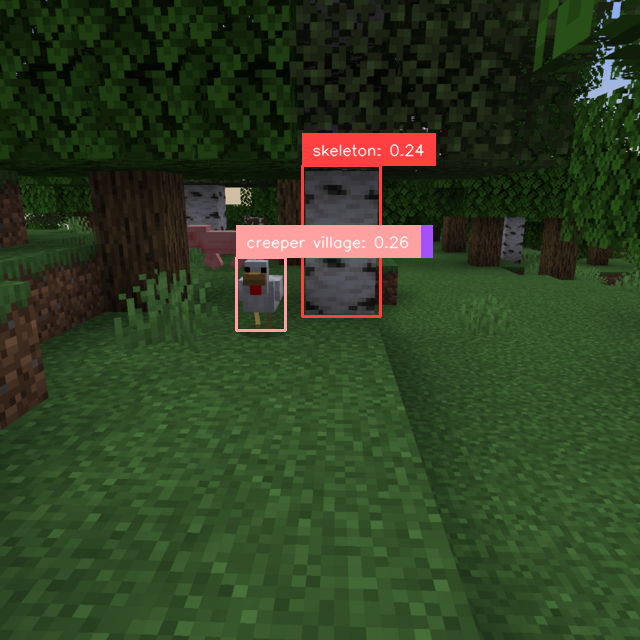

In [31]:
fname = mobs_path / '06092b21-2024-10-20_22.22.09.png'
image = infer(fname)
display(image)

In [24]:
class InferViewer:
    def __init__(self, image_dir: str | Path, glob_pat: str = "*.png"):
        self.image_dir = image_dir
        self.image_files = sorted(Path(image_dir).glob(glob_pat))
        self.current_file = None
        self.current_index = 0
    
    def view_image_cb(self, index: int):
        self.current_index = index
        self.current_file = self.image_files[index]
        
        image = infer(self.current_file)
        print(f"dir={self.image_dir} n_images={len(self.image_files)}")
        print(f"index={index} file={self.current_file.name}")
        display(image)
    
    def show_widget(self):
        slider = widgets.IntSlider(
            value=0,
            min=0,
            max=len(self.image_files) - 1,
            description='Image:',
            continuous_update=False
        )
        widgets.interact(self.view_image_cb, index=slider)


In [32]:
viewer = InferViewer(mobs_path)
viewer.show_widget()

interactive(children=(IntSlider(value=0, continuous_update=False, description='Image:', max=46), Output()), _d…

In [28]:
classes

['minecraft chicken',
 'minecraft cow',
 'minecraft creeper',
 'minecraft enderman',
 'minecraft pig',
 'minecraft player',
 'minecraft sheep',
 'minecraft skeleton',
 'minecraft spider',
 'minecraft villager',
 'minecraft zombie']